# Mid Project 2

## Handwritten Character Recognition

#### The aim of this project is to automatically convert handwritten text into machine encoded text.

## Importing Libraries

In [1]:
# Importing the libraries
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.style.use('fivethirtyeight')
import string
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation, BatchNormalization, Lambda, LSTM, Bidirectional, Embedding, Input, InputLayer
import keras.backend as K
import tensorflow.keras as keras

from keras.callbacks import ModelCheckpoint
import math
from sklearn.metrics import mean_squared_error

import cv2
from google.colab.patches import cv2_imshow
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

## Importing Datasets

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!ls -ltr "/content/drive/My Drive/Dataset/Mid_Project_2"

total 82989
-rw-------  1 root root  5297020 Apr 25 17:48 parser.txt
drwx------ 11 root root     4096 Apr 26 21:26 words
-rw-------  1 root root 79679112 May 16 00:21 handwritten_text_best_model.h5


In [4]:
colnames=['word_id', 'word_status', 'greylevel','bb_x','bb_y','bb_w','bb_h','tag','word'] 
data = pd.read_csv(r'/content/drive/My Drive/Dataset/Mid_Project_2/parser.txt',sep=' ', names = colnames)

In [5]:
data.head()

,word_id,word_status,greylevel,bb_x,bb_y,bb_w,bb_h,tag,word
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.


## Data Wrangling

In [6]:
data.shape

(75604, 9)

In [7]:
## Taking all correct dataset where statsu = 'ok'

data = data[data.word_status=='ok']

In [8]:
## Resetting the index
data.reset_index(inplace=True)

In [9]:
data.drop("index",axis = 1, inplace=True)

In [10]:
## Creating list of words which are not correctly loaded in dataframe
error_word=[]
error_word_index=[]
for i in range(0,max(data.index)+1):
  if data.iloc[i]["word"][0] == '\n':
    error_word.append([i, data.iloc[i]["word"]])
    error_word_index.append(i)
print(len(error_word))
print(error_word_index)
#print(error_word)

529
[226, 277, 645, 682, 728, 1172, 1306, 1364, 1396, 1398, 1445, 1449, 1453, 1456, 1459, 1462, 1471, 1473, 1482, 1484, 1489, 1494, 1508, 1565, 1578, 1601, 1611, 1952, 1979, 1985, 2058, 2106, 2128, 2154, 2178, 2204, 2233, 2781, 2785, 2798, 2835, 2900, 3056, 3121, 3147, 3162, 3308, 3312, 3335, 3353, 3798, 4587, 4767, 4873, 4883, 4885, 4915, 4924, 4952, 4983, 4993, 5017, 5030, 5039, 5116, 5608, 5679, 5691, 5716, 5765, 5794, 5803, 5831, 5878, 6606, 6773, 6977, 6994, 7029, 7045, 7074, 7079, 7091, 7104, 7107, 7109, 7135, 7138, 7158, 7161, 7163, 7241, 7277, 7281, 7305, 7381, 7403, 7404, 7437, 7485, 7501, 7516, 7554, 7633, 7673, 7689, 7693, 7715, 7811, 7921, 9458, 9577, 10075, 10552, 11017, 11086, 11402, 12188, 12490, 12686, 12705, 12723, 12741, 12758, 12770, 12786, 12790, 12851, 12985, 13043, 13075, 13097, 13208, 13309, 13327, 13376, 14826, 14831, 15032, 15034, 15040, 15114, 15116, 15123, 15128, 15147, 15151, 15156, 15158, 15164, 15170, 15176, 15182, 15188, 15194, 15200, 15215, 15241, 15256,

In [11]:
## dropping the words which are incorrect

data.drop(error_word_index,inplace=True)

In [12]:
## Resetting the index

data.reset_index(inplace=True)

In [13]:
data.drop("index",axis = 1, inplace=True)

In [14]:
## Taking first 10000 instances for training

data = data.iloc[:10000]

In [15]:
data.shape

(10000, 9)

In [16]:
data.head()

,word_id,word_status,greylevel,bb_x,bb_y,bb_w,bb_h,tag,word
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.


In [17]:
## Function to get path from word id

def file_path(word_id):
  w = word_id.split('-')
  drive_path = r'/content/drive/My Drive/Dataset/Mid_Project_2/words/'
  return (drive_path+w[0]+'/'+w[0]+'-'+w[1]+'/'+word_id+'.png')
##file_path(r'/content/drive/My Drive/Dataset/Mid_Project_2/words/','g07-065-07-05')

In [18]:
!ls -ltr "/content/drive/My Drive/Dataset/Mid_Project_2/words/g07/g07-065/g07-065-07-05.png"

-rw------- 1 root root 17028 Feb  4  2004 '/content/drive/My Drive/Dataset/Mid_Project_2/words/g07/g07-065/g07-065-07-05.png'


In [19]:
data['path'] = data['word_id'].apply(file_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [20]:
data.head()

,word_id,word_status,greylevel,bb_x,bb_y,bb_w,bb_h,tag,word,path
0,a01-000u-00-00,ok,154,408,768,27,51,AT,A,/content/drive/My Drive/Dataset/Mid_Project_2/...
1,a01-000u-00-01,ok,154,507,766,213,48,NN,MOVE,/content/drive/My Drive/Dataset/Mid_Project_2/...
2,a01-000u-00-02,ok,154,796,764,70,50,TO,to,/content/drive/My Drive/Dataset/Mid_Project_2/...
3,a01-000u-00-03,ok,154,919,757,166,78,VB,stop,/content/drive/My Drive/Dataset/Mid_Project_2/...
4,a01-000u-00-04,ok,154,1185,754,126,61,NPT,Mr.,/content/drive/My Drive/Dataset/Mid_Project_2/...


In [21]:
data.shape

(10000, 10)

In [22]:
## Stripping the word of extra spaces 

data["word"] = data["word"].map(lambda x: x.strip())

In [23]:
data.shape

(10000, 10)

In [24]:
## check if image exists at mentioned path:
file_not_found=[]
for i in range(0,max(data.index)+1):
  if not os.path.isfile(data.iloc[i]["path"]):
    file_not_found.append(i)

print(f"Count of missing images = {len(file_not_found)}")


Count of missing images = 0


### Functions for Images

In [25]:
## Function to view the image and label on it

def view_image(words,path):
  ##%pylab inline
  print('Word : '+ words+ "\t\t"+ path)
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)   
  img = cv2.resize(img, (128, 32)) 
  cv2_imshow(img)


Index = 100
Word : Labour		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-01-03.png


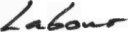

-----------------------

Index = 101
Word : M		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-01-04.png


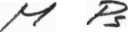

-----------------------

Index = 102
Word : are		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-01-05.png


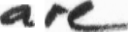

-----------------------

Index = 103
Word : likely		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-01-06.png


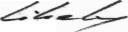

-----------------------

Index = 104
Word : to		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-01-07.png


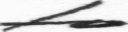

-----------------------

Index = 105
Word : turn		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-02-00.png


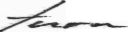

-----------------------

Index = 106
Word : down		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-02-01.png


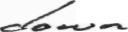

-----------------------

Index = 107
Word : the		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-02-02.png


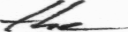

-----------------------

Index = 108
Word : Foot-Griffiths		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-02-03.png


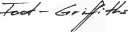

-----------------------

Index = 109
Word : resolution		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-02-04.png


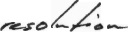

-----------------------

Index = 110
Word : .		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-02-05.png


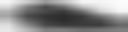

-----------------------

Index = 111
Word : Mr.		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-02-06.png


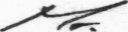

-----------------------

Index = 112
Word : Foot's		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-03-00.png


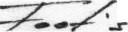

-----------------------

Index = 113
Word : line		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-03-01.png


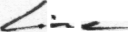

-----------------------

Index = 114
Word : will		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-03-02.png


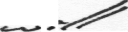

-----------------------

Index = 115
Word : be		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-03-03.png


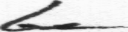

-----------------------

Index = 116
Word : that		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-03-04.png


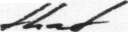

-----------------------

Index = 117
Word : as		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-03-05.png


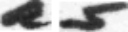

-----------------------

Index = 118
Word : Labour		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-03-06.png


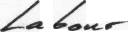

-----------------------

Index = 119
Word : M		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-03-07.png


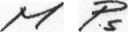

-----------------------

Index = 120
Word : opposed		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-04-00.png


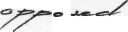

-----------------------

Index = 121
Word : the		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-04-01.png


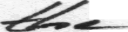

-----------------------

Index = 122
Word : Government		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-04-02.png


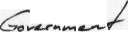

-----------------------

Index = 123
Word : Bill		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-04-03.png


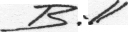

-----------------------

Index = 124
Word : which		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-04-04.png


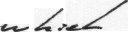

-----------------------

Index = 125
Word : brought		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-04-05.png


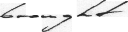

-----------------------

Index = 126
Word : life		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-05-00.png


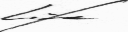

-----------------------

Index = 127
Word : peers		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-05-01.png


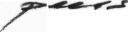

-----------------------

Index = 128
Word : into		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-05-02.png


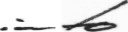

-----------------------

Index = 129
Word : existence		/content/drive/My Drive/Dataset/Mid_Project_2/words/a01/a01-003/a01-003-05-03.png


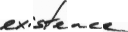

-----------------------



In [26]:
for i in range(100,130):
  print(f"Index = {i}")
  view_image(data['word'].iloc[i],data['path'].iloc[i])
  print("-----------------------\n")

In [27]:
## function to pre-process the image, resize and normalize

def image_processing(path,height=32,width=128):
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)   
  h,w = img.shape
  #print(h,w)

  if h < height:
      add_zeros = np.ones((height-h , w))*255
      img = np.concatenate((img, add_zeros))
      h = 32

  if w < width:
      add_zeros = np.ones((h, width-w))*255
      img = np.concatenate((img, add_zeros), axis=1)
      w = 128
  
  # Image resized [128 X 32]
  img = cv2.resize(img, (width, height)) 

  img = np.expand_dims(img , axis = 2)

  # Normalize the image between 0-1
  img = img/255.

  return img


### Function for text

In [28]:
## Creating list of characters

characters = string.ascii_letters + string.digits + string.punctuation 
print(characters)

abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [29]:
## Function to lable encode the characters

def LabelEncoder(label):
  return [characters.index(char) for char in label]

In [30]:
## Finding maximum length and size of vocabulary

max_len_word=0
word_set=set()

for i in range(0,max(data.index)+ 1):
  label= data.iloc[i].word
  max_len_word = max(max_len_word,len(label))
  for char in label:
        word_set.add(char)
word_set=list(word_set)
print(f"Maximum word length = {max_len_word}")
print(f"Length of unique characters = {len(word_set)}")
print(word_set)

Maximum word length = 15
Length of unique characters = 74
['F', 'E', 'm', 'A', 'P', 'Y', 'k', 'b', ')', '-', ':', 'l', 'L', '2', 'R', '6', 'U', 'Z', 'X', '(', '4', 'n', 'I', 'p', 't', 'v', 'e', ';', 's', '3', 'C', '#', 'q', 'c', 'w', 'o', 'd', 'j', 'B', 'D', 'a', 'K', 'T', '?', "'", 'W', 'u', '9', 'S', 'r', '5', '*', 'J', 'z', ',', '1', 'H', '0', 'V', 'N', 'x', 'Q', '!', 'i', 'h', 'O', 'f', '8', '7', '.', 'y', 'G', 'M', 'g']


In [31]:
## checking if numeric value of word exists or not:
check = 0
for w in word_set:
  if w not in characters:
    print(w)
if check > 0:
  print("words are missing from character set")
else:
  print("all words are present")

all words are present


In [32]:
## Function to create features and target for training the model
def create_image_label(df):
  X=[]
  Y=[]
  image_length = 31
  error_record = []
  start = datetime.datetime.today()
  print(f"Start -> {start}")

  for i in range(0,max(df.index)+1):
    try:
      X.append([image_processing(df.iloc[i]["path"]),image_length,df.iloc[i]["path"]])
      Y.append([ LabelEncoder(df.iloc[i]["word"]), len(df.iloc[i]["word"]), df.iloc[i]["word"]  ])

      if i % 100 == 0:
        end = datetime.datetime.today()
        total_time = round((end - start).total_seconds(),2)
        print(f"Data is calculated till label = {i} \t\t Time Taken = {total_time} sec.")
        start = datetime.datetime.today()

      # if i > 200 :
      #   break
    except:
      print(f"Error found for index position = {i}")
      error_record.append(i)
      pass

  print(f"Count of error_records ={len(error_record)}")
  print(f"End -> {datetime.datetime.today()}")

  return X,Y,error_record

### Creating Data Set for Model Training

In [33]:
## Create X and Y label for model training

X,Y,ERR = create_image_label(data)

Start -> 2022-05-16 00:21:45.055313
Data is calculated till label = 0 		 Time Taken = 0.01 sec.
Data is calculated till label = 100 		 Time Taken = 0.32 sec.
Data is calculated till label = 200 		 Time Taken = 0.31 sec.
Data is calculated till label = 300 		 Time Taken = 0.35 sec.
Data is calculated till label = 400 		 Time Taken = 0.33 sec.
Data is calculated till label = 500 		 Time Taken = 0.32 sec.
Data is calculated till label = 600 		 Time Taken = 0.33 sec.
Data is calculated till label = 700 		 Time Taken = 0.33 sec.
Data is calculated till label = 800 		 Time Taken = 0.33 sec.
Data is calculated till label = 900 		 Time Taken = 0.34 sec.
Data is calculated till label = 1000 		 Time Taken = 0.34 sec.
Data is calculated till label = 1100 		 Time Taken = 0.34 sec.
Data is calculated till label = 1200 		 Time Taken = 0.39 sec.
Data is calculated till label = 1300 		 Time Taken = 0.36 sec.
Data is calculated till label = 1400 		 Time Taken = 0.36 sec.
Data is calculated till label =

### Test Train Split

In [34]:
## Performing test train split using sklearn

X_train_tmp,X_test_tmp,y_train_tmp,y_test_tmp = train_test_split(X, Y, test_size = 0.2, random_state = 48)

In [35]:
## Checking the count of training and test data set

print(f"Size of X label = {len(X)}")
print(f"Size of Y label = {len(Y)}")
print(f"Size of X_train label = {len(X_train_tmp)}")
print(f"Size of X_test label = {len(X_test_tmp)}")
print(f"Size of y_train label = {len(y_train_tmp)}")
print(f"Size of y_test label = {len(y_test_tmp)}")
print(f"Max Length of label = {max_len_word}")


Size of X label = 9999
Size of Y label = 9999
Size of X_train label = 7999
Size of X_test label = 2000
Size of y_train label = 7999
Size of y_test label = 2000
Max Length of label = 15


In [36]:
# Train data
x_train = [item[0] for item in X_train_tmp]
train_input_length = [item[1] for item in X_train_tmp]
train_image_path = [item[2] for item in X_train_tmp]

y_train = [item[0] for item in y_train_tmp]
train_label_length = [item[1] for item in y_train_tmp]
train_label_original = [item[2] for item in y_train_tmp]

# Test data
x_test = [item[0] for item in X_test_tmp]
test_input_length = [item[1] for item in X_test_tmp]
test_image_path = [item[2] for item in X_test_tmp]

y_test = [item[0] for item in y_test_tmp]
test_label_length = [item[1] for item in y_test_tmp]
test_label_original = [item[2] for item in y_test_tmp]

#### Padding all words to have similar length

In [37]:
train_pad_label = pad_sequences(y_train, maxlen=max_len_word, padding='post', value = len(characters))
test_pad_label = pad_sequences(y_test, maxlen=max_len_word, padding='post', value = len(characters))

## Creating Model for training

In [38]:
"""
a) Add several CNN layers to extract the sequence of features
b) Add Bi-LSTM layers to propagate through the sequence
c) Add a dense layer (output layer) with total number of neurons as (total number of characters + 1) and the activation as softmax.
"""

# input with shape of height=32 and width=128 
inputs = Input(shape=(32,128,1))

# CNN layrer
conv_1 = Conv2D(64,(3,3), input_shape=(32,128,1), padding="same", activation='relu', name="conv_1") (inputs)

# Maxpooling layer
pool_1 = MaxPooling2D(pool_size=(2,2), strides=2) (conv_1)

conv_2 = Conv2D(128,(3,3), padding="same", activation='relu', name="conv_2") (pool_1)
pool_2 = MaxPooling2D(pool_size=(2,2), strides=2) (conv_2)

conv_3 = Conv2D(256,(3,3), padding="same", activation='relu', name="conv_3") (pool_2)

conv_4 =Conv2D(256,(3,3), padding="same", activation='relu', name="conv_4") (conv_3)
pool_3 = MaxPooling2D(pool_size=(2,1)) (conv_4)

conv_5 = Conv2D(512,(3,3), padding="same", activation='relu', name="conv_5") (pool_3)

# Normlization layer
batch_norm_1 = BatchNormalization() (conv_5)

conv_6 = Conv2D(512,(3,3), padding="same", activation='relu', name="conv_6") (batch_norm_1)

# Normlization layer
batch_norm_2 = BatchNormalization() (conv_6)

pool_4 = MaxPooling2D(pool_size=(2,1)) (batch_norm_2)

# Last CNN layer and used dilation_rate to defines a spacing between the values in a kernel. It return shape "(None, 1, 31, 512) from (None, 2, 32, 512)"
conv_7 = Conv2D(512,(2,2), dilation_rate=(1, 1), activation='relu', name="conv_7") (pool_4)

# Used a lambda function and Squeeze function of keras beckend to squeeze the output shape of CNN layer and make it compatible with LSTM layer as input.
squeezed = Lambda(lambda x: K.squeeze(x, 1)) (conv_7)

# Add two LSTM layers with dropout
bi_lstm_1 = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2)) (squeezed)
bi_lstm_2 = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.2)) (bi_lstm_1)

# Last dense layer with activation "Softmax"
outputs = Dense(len(characters)+1, activation='softmax', name="output") (bi_lstm_2)


#create a model using input and output of layers to use for prediction.
actual_model = keras.Model(inputs, outputs)
actual_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 128, 1)]      0         
                                                                 
 conv_1 (Conv2D)             (None, 32, 128, 64)       640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 64, 64)       0         
 )                                                               
                                                                 
 conv_2 (Conv2D)             (None, 16, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 32, 128)       0         
 2D)                                                             
                                                                 
 conv_3 (Conv2D)             (None, 8, 32, 256)        295168

### CTC layer (CTC_loss)

In [39]:
labels = Input(name='the_labels', shape=[max_len_word], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')


def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([outputs, labels, input_length, label_length])

# New model has been  created for training only
model = keras.Model(inputs=[inputs, labels, input_length, label_length], outputs=loss_out)

In [40]:
## Compiling the model

model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer = 'adam')

In [41]:
## Creating Checkpoint to save the best model

filepath= r'/content/drive/My Drive/Dataset/Mid_Project_2/handwritten_text_best_model.h5'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]

### Training the model

In [42]:
#convert the train and test data in numpy array

x_train = np.array(x_train)
train_input_length = np.array(train_input_length)
train_label_length = np.array(train_label_length)
 
x_test = np.array(x_test)
test_input_length = np.array(test_input_length)
test_label_length = np.array(test_label_length)

In [43]:
# training the model
model.fit(
    x=[x_train, train_pad_label, train_input_length, train_label_length], 
    y=np.zeros(len(x_train)), 
    batch_size=256, 
    epochs = 100, 
    validation_data = ([x_test, test_pad_label, test_input_length, test_label_length], 
                       [np.zeros(len(x_test))]), 
    verbose = 1, 
    callbacks = callbacks_list)

Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 24.2400
Epoch 1: val_loss improved from inf to 16.66320, saving model to /content/drive/My Drive/Dataset/Mid_Project_2/handwritten_text_best_model.h5
32/32 [==============================] - 103s 3s/step - loss: 24.2400 - val_loss: 16.6632
Epoch 2/100
32/32 [==============================] - ETA: 0s - loss: 16.5132
Epoch 2: val_loss improved from 16.66320 to 16.42391, saving model to /content/drive/My Drive/Dataset/Mid_Project_2/handwritten_text_best_model.h5
32/32 [==============================] - 94s 3s/step - loss: 16.5132 - val_loss: 16.4239
Epoch 3/100
32/32 [==============================] - ETA: 0s - loss: 15.6134
Epoch 3: val_loss did not improve from 16.42391
32/32 [==============================] - 92s 3s/step - loss: 15.6134 - val_loss: 17.8850
Epoch 4/100
32/32 [==============================] - ETA: 0s - loss: 14.8952
Epoch 4: val_loss did not improve from 16.42391
32/32 [==============================] 

### Saving the best model

In [44]:
model.save(r'/content/drive/My Drive/Dataset/Mid_Project_2/handwritten_text_best_model.h5')

### Loading the best model

In [45]:
actual_model.load_weights(r'/content/drive/My Drive/Dataset/Mid_Project_2/handwritten_text_best_model.h5')

## Predicting with model

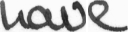

nae




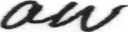

on




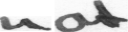

not




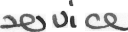

service




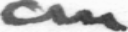

on




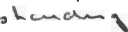

stumoing




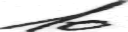

to




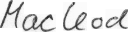

Macleod




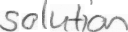

soletion




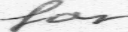

for




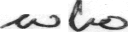

wbo




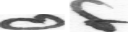

of




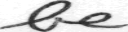

be




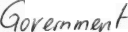

Goremment




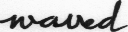

naed




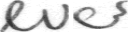

wew




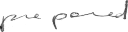

preponet




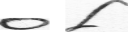

of




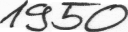

190




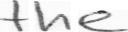

the




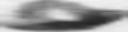

.




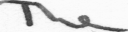

The




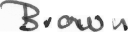

Browuwn




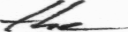

the




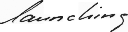

Lamctiong




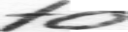

to




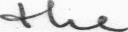

the




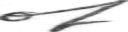

of




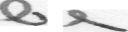

be




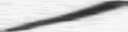

,




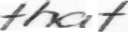

that




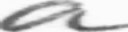

a




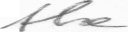

the




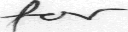

for




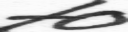

to




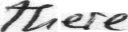

there




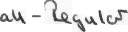

al-egruls




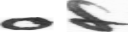

of




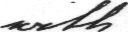

wth




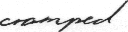

cronped




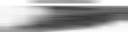

,




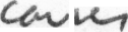

cowen




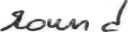

round




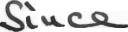

Since




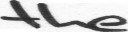

the




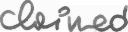

cleined




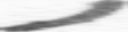

,




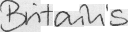

Bitain's




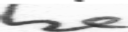

be




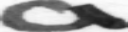

a




In [46]:
## CTC layer decode function

# predict outputs on test images
prediction = actual_model.predict(x_test)

# use CTC decoder
out = K.get_value(K.ctc_decode(prediction, 
                  input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                  greedy=True)[0][0])


# see the results
i = 0
for x in out:
  if i<50:

    # Read the path of image from list that has created after split of X and Y and show the same image
    path = test_image_path[i]
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)   
    img = cv2.resize(img, (128, 32)) 
    cv2_imshow(img)

    for p in x:  
      if int(p) != -1:
         print(characters[int(p)], end = '')       
    print('\n\n')
    i+=1


In [47]:
## Function to calculate % of prediction

def calc_accuracy(model, test_label_original):
  prediction = actual_model.predict(x_test)

  out = K.get_value(K.ctc_decode(prediction, input_length=np.ones(prediction.shape[0])*prediction.shape[1],
                          greedy=True)[0][0])
  test_size = len(x_test);
  true_predict =0
  false_predict =0;
  f_len =0
  t_len =0

  i = 0
  for x in out:
    actual = test_label_original[i]
    pred =''
    for p in x:     
      if int(p) != -1:
          pred += characters[int(p)]     

    if actual == pred:
      true_predict += 1
      t_len += len(actual)
    else:
      false_predict +=1
      f_len += len(actual)
    i+=1

  true_ratio = ( true_predict * 100 ) / test_size
  false_ratio = ( false_predict * 100 ) / test_size
  
  print('True Predict: ',true_ratio,'\n')
  print('True Predicted Words Length: ',t_len,'\n')
  print('False Predicted Words Length: ',f_len,'\n')
  return true_ratio

In [48]:
acc = calc_accuracy(actual_model, test_label_original)

True Predict:  52.75 

True Predicted Words Length:  3399 

False Predicted Words Length:  5521 

